<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/competicion-%20Angeles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocesamiento de las imagenes

## Descarga de las imagenes desde Github


In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

81059840/81057027 [==============================] - 1s 0us/step


In [3]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 72
drwxr-xr-x 28 root root  4096 Mar  4 15:48 ImagesTrain
drwxr-xr-x  2 root root 69632 Mar  4 15:48 Test


In [4]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2600


In [5]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

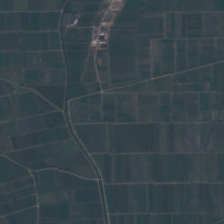

In [6]:
broadleaf_cropland = list(train_path.glob('Broadleaf_Cropland/*'))
PIL.Image.open(str(broadleaf_cropland[1]))

## Creacción de conjuntos de datos para entrenamiento y validacion

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=2021,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2600 files belonging to 26 classes.
Using 2080 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=2021,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2600 files belonging to 26 classes.
Using 520 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Broadleaf_Cropland', 'Cereal_Cropland', 'Close_Shrubland', 'Continental_Water', 'Cropland__with_seasonal_water', 'Forest_CDB', 'Forest_CDN', 'Forest_CEB', 'Forest_CEN', 'Forest_DDB', 'Forest_DDN', 'Forest_DEB', 'Forest_DEN', 'Forest_ODB', 'Forest_ODN', 'Forest_OEB', 'Forest_OEN', 'Grassland', 'Mangrove', 'Marine_Water', 'Marshland_add', 'Moss_and_Lichen', 'Open_Shrubland', 'Snow', 'Swamp', 'Urban']


## Visualiza Datos

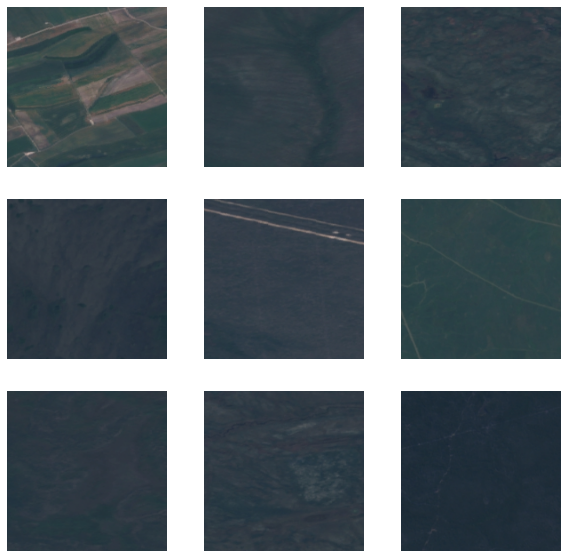

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.8/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
train_ds_gen = ImageDataGenerator(rotation_range=50,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.2)

In [ ]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

In [ ]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

In [ ]:
valid_data_gen.n

### Test Model


In [14]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.applications import ResNet50V2
from keras.models import Sequential, Model, load_model 
from keras.optimizers import Adadelta 
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K

In [15]:
def build_model():  

  pretrained_model = ResNet50V2(input_shape=(180, 180, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')

  for k,v in pretrained_model._get_trainable_state().items():
    k.trainable = False

  new_model = Sequential()
  new_model.add(pretrained_model)
  new_model.add(Dense(2048,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dropout(0.25))
  new_model.add(Dense(2048,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dropout(0.25))
  new_model.add(Dense(1024,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dropout(0.25))
  new_model.add(Dense(1024,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dropout(0.25))
  new_model.add(Dense(512,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dropout(0.25))
  new_model.add(Dense(256,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dense(128,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dense(64,activation='relu'))
  new_model.add(BatchNormalization())
  new_model.add(Dense(26, activation='softmax'))
  

  return new_model

In [16]:
n_classes = 26


In [17]:
!pip install tensorflow-addons


     |████████████████████████████████| 706kB 6.6MB/s 


In [18]:
import tensorflow_addons as tfa


In [19]:
model = build_model() 
optimizer = Adadelta(lr=1.5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(num_classes=n_classes), "accuracy"])

model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________

In [23]:
model_history = model.fit(  
    train_ds,
    epochs=40,
    validation_data=val_ds)

Epoch 1/40
65/65 [==============================] - 260s 4s/step - loss: 1.4982 - f1_score: 0.4594 - accuracy: 0.4644 - val_loss: 10.6892 - val_f1_score: 0.1313 - val_accuracy: 0.1865
Epoch 2/40
65/65 [==============================] - 257s 4s/step - loss: 1.4507 - f1_score: 0.4789 - accuracy: 0.4861 - val_loss: 14.6593 - val_f1_score: 0.0617 - val_accuracy: 0.0827
Epoch 3/40
65/65 [==============================] - 258s 4s/step - loss: 1.4047 - f1_score: 0.5047 - accuracy: 0.5115 - val_loss: 13.7219 - val_f1_score: 0.0153 - val_accuracy: 0.0885
Epoch 4/40
65/65 [==============================] - 257s 4s/step - loss: 1.3921 - f1_score: 0.4939 - accuracy: 0.5024 - val_loss: 15.6252 - val_f1_score: 0.0469 - val_accuracy: 0.0788
Epoch 5/40
65/65 [==============================] - 258s 4s/step - loss: 1.3762 - f1_score: 0.5082 - accuracy: 0.5159 - val_loss: 16.1400 - val_f1_score: 0.0531 - val_accuracy: 0.0885
Epoch 6/40
65/65 [==============================] - 258s 4s/step - loss: 1.2890 

In [25]:
model.save("model_base.h5")